# Steel Plate Defect Prediction


<img src='https://www.thinmetalsales.com/wp-content/uploads/METAL-METAL-METAL-METAL-METAL-METAL-METAL-METAL-METAL-MANUFACTURING-1.jpg' />


This is a KAGGLE Competition on predicting the probability of various defects on steel plates.

There are 7 defect types: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The objective is to predict the probability of each of the 7 binary targets of the test set. 

The data is already split in Train and Test sets. The Train set will be used to train the model and the Test set will be used to make prediction for the competition submission.


**Defects**

Before continuing with creating the predictive models, in this section are explained each of the steel plate defect types.

* <code>Pastry</code>: Pastry are small patches on the surface of the steel plate. These imperfections can affect the surface smoothness and appearance of the steel plate.

* <code>Z_Scratch</code>: Z-scratches are narrow scratches or marks on the surface of the steel plate that run parallel to the rolling direction.

* <code>K_Scratch</code>: K-scratches are similar to Z-scratches but run perpendicular to the rolling direction. 

* <code>Stains</code>: Stains refer to discolored or contaminated areas on the surface of the steel plate.

* <code>Dirtiness</code>: Dirtiness indicates the presence of dirt or particulate matter on the surface of the steel plate.

* <code>Bumps</code>: Bumps are raised or protruding areas on the surface of the steel plate. 

* <code>Other_Faults</code>: This could include various types of surface imperfections, irregularities, or abnormalities that affect the quality of the steel plate.

## Importing Libraries

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE

## Reading the data

In [2]:
# Setting the pandas condition to display all columns of the dataframes

pd.set_option('display.max_columns', None)

In [3]:
# Locating the zip file in this directory
file = zipfile.ZipFile('..\Data\playground-series-s4e3.zip')

# Printing the filelist
for i in file.filelist:
    print(i.filename)

sample_submission.csv
test.csv
train.csv


In [4]:
# Openning the zip file and reading the provided csv file from KAGGLE

with file.open('train.csv') as t:
    df_train = pd.read_csv(t)
    
    
with file.open('test.csv') as te:
    df_test = pd.read_csv(te)

In [128]:
df_test

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.3877,0.4896,0.3273,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.1629,0.4136,0.0938,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.0609,0.6234,0.4762,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.4439,0.3333,0.8182,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.8191,0.2619,0.4286,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,32028,1101,1116,447943,447992,313,32,37,21603,79,103,1353,0,1,70,0.2853,0.3050,0.2339,0.0126,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894
12810,32029,1289,1306,3149494,3149542,59,9,18,5249,113,141,1362,0,1,40,0.0106,0.2778,0.2778,0.0052,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954
12811,32030,41,210,1587535,1587191,16584,796,522,1858162,24,143,1400,0,1,40,0.0557,0.5644,0.9371,0.1236,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000
12812,32031,1329,1340,702237,702267,386,43,34,36875,66,124,1364,0,1,40,0.0133,0.1814,0.1539,0.0095,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844


## Exploring the df

In [5]:
print('The train df contains {} rows and {} columns'.format(df_train.shape[0], df_train.shape[1]))

print('The test df contains {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))

The train df contains 19219 rows and 35 columns
The test df contains 12814 rows and 28 columns


In [6]:
# Showing a sample of the dataset

df_train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [7]:
# Defining the targets of the dataset (7 types of steel plate defects)

targets = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

Before continuing, lets check the values of the targets: <code>["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]</code>. <br>
The targets are binay, meaning that they would have values 0 and 1 and each column represents a different defect as mentioned above. In the secion below, we will check whether we have cases with more than one defect or if we have cases without defect.

In [8]:
# Checking whether we have targets without faults or with more than one fault

df_train[targets].sum(axis=1).value_counts()

1    18380
0      818
2       21
dtype: int64

From above, we can understand that we have cases without any defect **(818 cases)** and cases than have more than one defect **(21 Cases)**. <br>
Since our goal is to predict the type of defect in the SteelPlate rather than simply determining whether it has a defect or not, we will exclude the 818 cases that do not exhibit any defects. <br>
For the cases that have more than one defect, we will analyze them to check whether we should take any action.

In [9]:
# Removing cases with no fault

df_train = df_train[df_train[targets].sum(axis=1) > 0]

In [10]:
# Cases with more than one defect
multiple_targets_rows = df_train[targets].sum(axis=1) > 1
df_train.loc[multiple_targets_rows][targets]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1
8538,0,0,1,0,0,0,1


Since all the cases are "K_Scatch" cases, we will set the value 0 to other defects for these 21 rows

In [11]:
# Setting other target columns to 0 for rows with multiple targets
df_train.loc[multiple_targets_rows, targets[:]] = 0

# Setting "K_Scatch" to 1 for rows with multiple targets
df_train.loc[multiple_targets_rows, "K_Scatch"] = 1

In [12]:
# Checking again the targets values

df_train[targets].sum(axis=1).value_counts()

1    18401
dtype: int64

In [13]:
# Concatening train and the test sets in one dataframe

total_df = pd.concat([df_train, df_test])

In [14]:
# Checking the null values of the df

total_df.isnull().sum()

id                           0
X_Minimum                    0
X_Maximum                    0
Y_Minimum                    0
Y_Maximum                    0
Pixels_Areas                 0
X_Perimeter                  0
Y_Perimeter                  0
Sum_of_Luminosity            0
Minimum_of_Luminosity        0
Maximum_of_Luminosity        0
Length_of_Conveyer           0
TypeOfSteel_A300             0
TypeOfSteel_A400             0
Steel_Plate_Thickness        0
Edges_Index                  0
Empty_Index                  0
Square_Index                 0
Outside_X_Index              0
Edges_X_Index                0
Edges_Y_Index                0
Outside_Global_Index         0
LogOfAreas                   0
Log_X_Index                  0
Log_Y_Index                  0
Orientation_Index            0
Luminosity_Index             0
SigmoidOfAreas               0
Pastry                   12814
Z_Scratch                12814
K_Scatch                 12814
Stains                   12814
Dirtines

We don't have any null values in this DataFrame. The null values are present only in the target labels, with the exact number matching the length of the test DataFrame

In [15]:
# Descriptive Analysis of the train df

total_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,31215.000000,31215.000000,31215.000000,3.121500e+04,3.121500e+04,31215.000000,31215.000000,31215.000000,3.121500e+04,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,31215.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000,18401.000000
mean,16184.768637,708.190165,752.525677,1.854290e+06,1.850125e+06,1698.853019,96.685247,64.708794,1.941326e+05,84.479609,128.606792,1459.892007,0.404934,0.594073,75.791286,0.352177,0.408512,0.575053,0.030935,0.616627,0.832003,0.588009,2.476561,1.314108,1.390051,0.100283,-0.139447,0.572199,0.079615,0.062497,0.186512,0.030868,0.026357,0.258736,0.355415
std,9263.945473,532.447505,500.594578,1.911864e+06,1.904240e+06,3750.566565,196.998473,143.845935,4.609339e+05,28.735434,14.115994,145.893711,0.490887,0.491078,53.312520,0.318855,0.124000,0.258672,0.048201,0.221140,0.221335,0.482747,0.764101,0.470280,0.404021,0.487294,0.118440,0.332374,0.270704,0.242062,0.389530,0.172964,0.160200,0.437952,0.478652
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,4.000000,2.000000,2.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.066700,0.000000,0.778200,0.301000,0.000000,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8157.500000,46.000000,214.000000,6.574680e+05,6.531950e+05,90.000000,15.000000,14.000000,9.948000e+03,68.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.316700,0.375800,0.006600,0.454500,0.655700,0.000000,1.954200,1.000000,1.079200,-0.272700,-0.192600,0.257000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16294.000000,775.000000,793.000000,1.398598e+06,1.398179e+06,169.000000,25.000000,24.000000,1.832700e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413000,0.545400,0.009500,0.636400,0.965500,1.000000,2.227900,1.146100,1.322200,0.111100,-0.143500,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24228.500000,1152.000000,1165.500000,2.368336e+06,2.368203e+06,657.000000,65.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.653450,0.493700,0.818200,0.019100,0.785700,1.000000,1.000000,2.817600,1.431400,1.707600,0.526300,-0.084400,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,32032.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.747200,1.000000,1.000000,1.000000,4.680200,2.997300,4.258700,0.991700,0.591700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Checking if we have duplicated values

total_df.duplicated().sum()

0

There are no duplicate values on the df

# EDA (Exploratory Data Analysis)

In [17]:
sns.set_style('darkgrid')

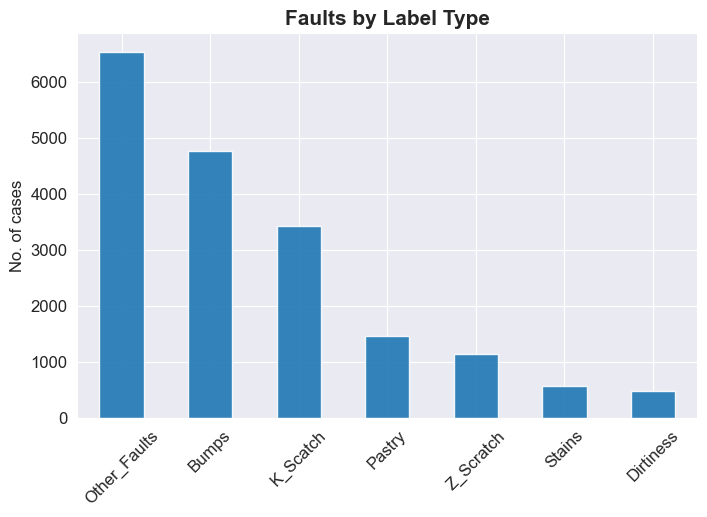

In [18]:
# Plotting Faults by the label type

faults_by_type = df_train[targets].sum().sort_values(ascending = False)

faults_by_type.plot(kind='bar', alpha = 0.9, figsize=(8,5))
plt.title('Faults by Label Type', fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize=12)
plt.ylabel('No. of cases', fontsize=12)

plt.show()

From the above chart we can observe that the majority of the cases are "Other_Faults", followed by "Bumps" and "K_Scatch"

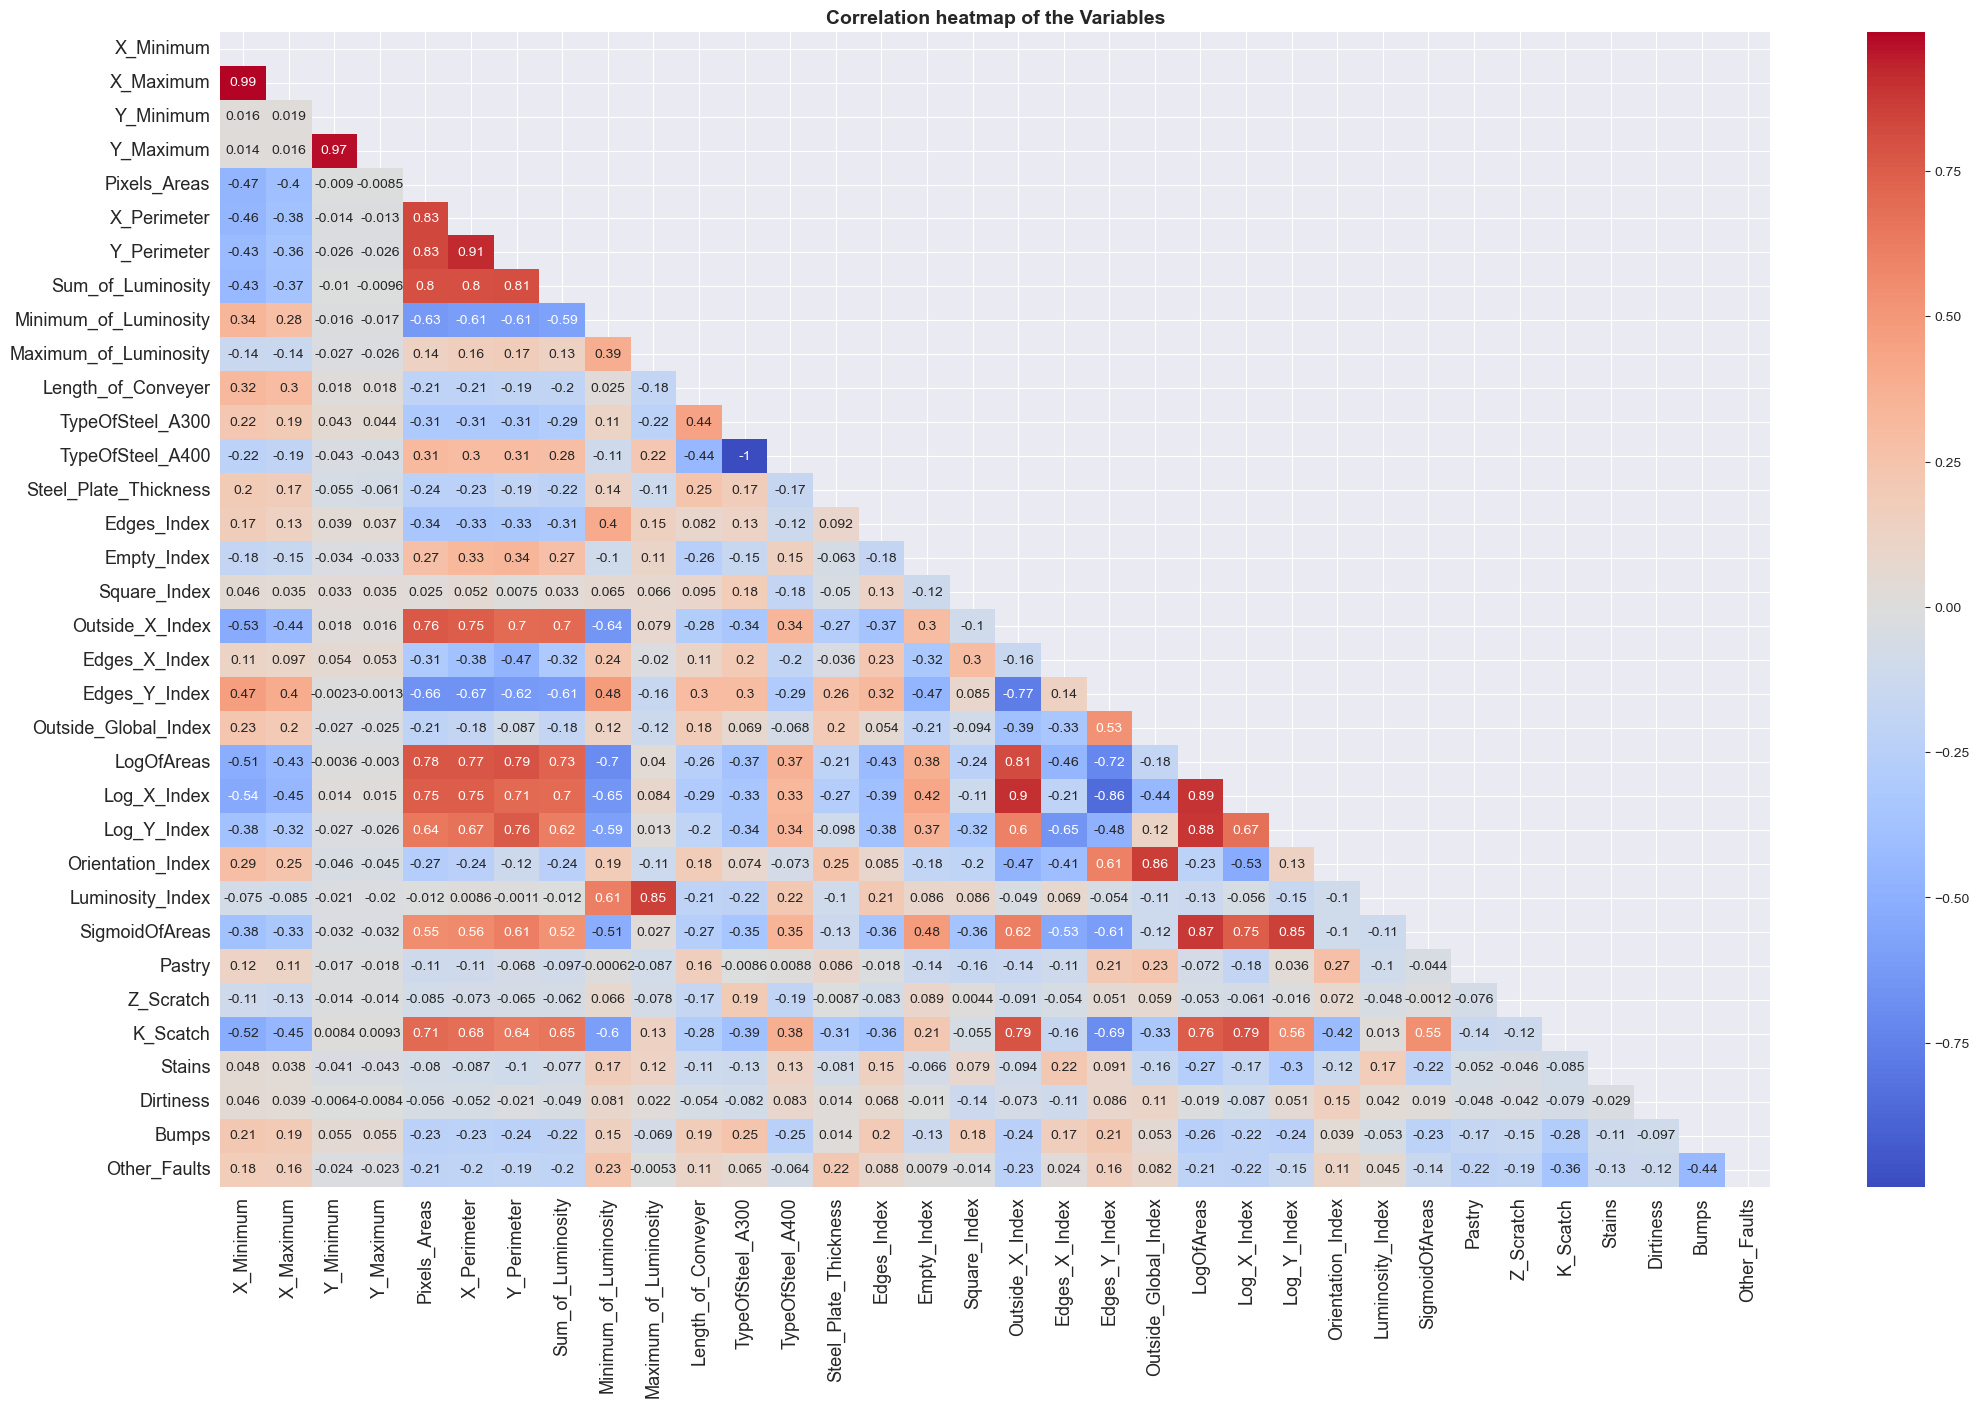

In [19]:
# Plotting the heatmap of correlations between features

fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(data=df_train.drop('id',axis=1).corr(), 
        annot=True, 
        mask = np.triu(np.ones_like(df_train.drop('id',axis=1).corr(), dtype=bool)),
           cmap='coolwarm')

plt.title('Correlation heatmap of the Variables', fontsize=14, fontweight = 'bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

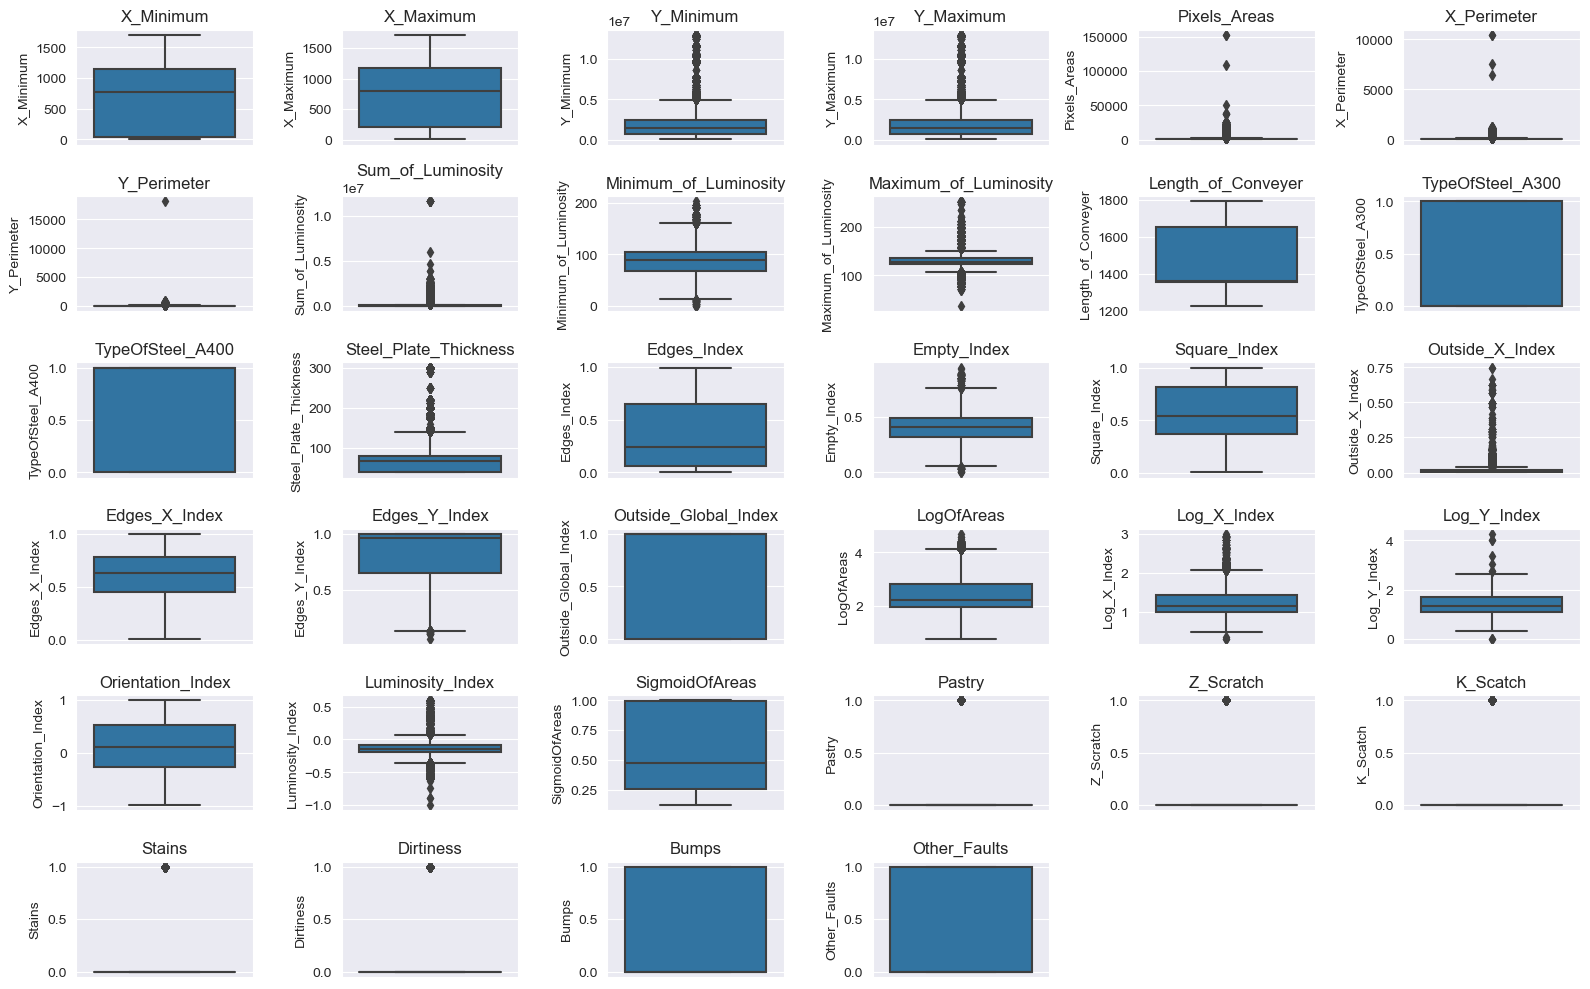

In [20]:
# Plotting the distribution of the columns

plt.figure(figsize=(16, 10))

for i, column in enumerate(total_df.drop('id',axis=1), start=1):
    plt.subplot(6, 6, i)
    sns.boxplot(y=total_df[column])
    plt.title(column)

plt.tight_layout()
plt.show();

As it is seen above many features exhibit a wide range of values. These points could be critical factors in the model's construction.

### t-SNE plot

Since we have multiple features, it's challenging to visually inspect the relationships between them. Therefore, we'll employ a dimensionality reduction technique to plot all the data in two axes. The method we'll utilize is called t-SNE.

t-SNE stands for t-distributed Stochastic Neighbor Embedding. It's a nonlinear dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space, typically two or three dimensions. t-SNE works by modeling the relationships between data points in such a way that similar points in the high-dimensional space are modeled as nearby points in the lower-dimensional space.

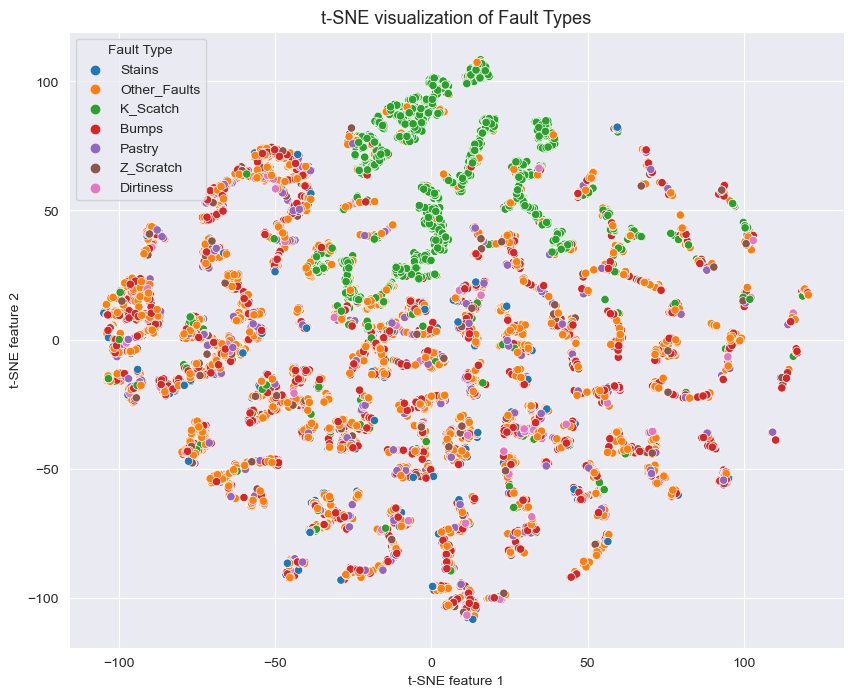

In [21]:
# Copying the df that will be used for plotting
train_df_plot = df_train.drop('id', axis=1).copy()

# defining a function to create a new column with the name of defects
def fault_label(row):
    labels = [col for col in targets if row[col] == 1]
    if not labels:  # If the list is empty, return 'None'
        return 'None'
    return ', '.join(labels)

# Applying the function to each row to create the new 'Fault' column
train_df_plot['Fault'] = train_df_plot.apply(fault_label, axis=1)


# Separating features and labels
X_plot = train_df_plot.drop('Fault', axis=1)
X_plot = X_plot.drop(targets, axis=1)
y_plot = train_df_plot['Fault']

# Performing t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X_plot)

# Creating a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_plot, legend='full')
plt.title('t-SNE visualization of Fault Types', fontsize = 13)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(title='Fault Type')
plt.show()

From the plot above, we can infer that k_Scatch is separated from other faults, making it potentially easier to predict these cases. However, for the other faults, they are almost uniformly spread.

## Feature Engineering

In [18]:
# Creating a function for feature engineering

def feature_engineering(df):
    """
    This function is created to make the feature engineering process of this dataset
    """
    # Calculating the X_distance from X_Maximum and X_Minimum
    df['X_distance'] = df['X_Maximum'] - df['X_Minimum']
    
    # Calculating the Y_distance from Y_Maximum and Y_Minimum
    df['Y_distance'] = df['Y_Maximum'] - df['Y_Minimum']
    
    # Calculating the difference of Maximum_of_Luminosity and Minimum_of_Luminosity
    df['Color_contrast'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']
    
    # Calculating the Density
    df['Density'] = df['Pixels_Areas'] / (df['X_Perimeter'] + df['Y_Perimeter'])
    
    return df

In [19]:
# Calculating the feature engineered columns

total_df = feature_engineering(total_df)

In [20]:
# Showing a sample of the df
total_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_distance,Y_distance,Color_contrast,Density
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,5,27,1.230769
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,22,41,5.851351
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,153,68,112,10.122667
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,27,20,4.666667
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,45,29,3.748201


## Training the models

### Splitting the data into train and test sets

In [21]:
# Spliting train and test df after processing

# Train df
train_df = total_df[:df_train.shape[0]]

# Test df
test_df = total_df[df_train.shape[0]:].dropna(axis=1)

In [22]:
# Dropping the 'id' column from train df
train_df = train_df.drop('id', axis=1).copy()

train_df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_distance,Y_distance,Color_contrast,Density
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,5,27,1.230769
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,22,41,5.851351
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,153,68,112,10.122667
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,27,20,4.666667
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,45,29,3.748201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,143210,143219,17,4,4,2193,122,140,1360,0,0,50,0.8950,0.1500,0.8571,0.0044,1.0000,0.8000,0.0,1.2305,0.7782,0.6021,-0.1429,0.0044,0.2901,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8,9,18,2.125000
19215,723,735,2488529,2488541,231,17,26,27135,104,133,1652,1,0,70,0.9243,0.3254,0.2778,0.0065,0.7333,0.9216,1.0,2.3636,1.0414,1.4150,0.7222,-0.0989,0.5378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12,12,29,5.372093
19216,6,31,1578055,1578129,780,114,98,71112,41,94,1358,0,1,200,0.0148,0.4331,0.2281,0.0199,0.1862,0.9554,1.0,2.8921,1.4314,1.8692,0.7719,-0.4283,0.9997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25,74,53,3.679245
19217,9,18,1713172,1713184,126,13,26,14808,88,132,1692,1,0,60,0.0192,0.2361,0.0390,0.0068,0.7692,1.0000,1.0,2.1004,1.0414,1.4150,0.9610,-0.1162,0.3509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9,12,44,3.230769


### Scaling the features

Based on the researches, when we use regularization techniques it is better to scale the data. In this notebook we intend to use models with regularization included

In [23]:
# Getting the features in a list from the train df

features=list(train_df.drop(columns=targets,axis=1))

From all the features, we have only two categorical variables: 'TypeOfSteel_A300','TypeOfSteel_A400'

In [24]:
# Identifying categorical variables

cat_features=['TypeOfSteel_A300','TypeOfSteel_A400']

In [25]:
# Defining columns to scale (Excluding cat_features)

scale_cols = features.copy()
for f in cat_features:
    scale_cols.remove(f)

In [26]:
# Scaling the train and thest sets using StandardScaler
scaler = StandardScaler()
train_df.loc[:, scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df.loc[:, scale_cols] = scaler.transform(test_df[scale_cols])

### Defining features and targets (X, y)

In [27]:
X = train_df.drop(targets, axis = 1)

y = train_df[targets]

y_arr = y.to_numpy()

y_arr = np.argmax(y_arr, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_arr,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14720, 31), (3681, 31), (14720,), (3681,))

In [28]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled.shape, y_train_resampled.shape

((36988, 31), (36988,))

### Models

#### Xgboost Model

In [142]:
# %%time

# #Performing the random search on Xgboost Model
# # Define the parameter grid
# param_grid = {
    
#     'learning_rate': [0.00988, 0.01],# , 0.1],
#     'max_depth': [4],#, 5, 6, 7],
#     'subsample': [0.75, 0.8],# , 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.65],#, 0.9, 1.0],
#     'reg_alpha': [0.16, 0.17],#, 0.5, 1.0],
#     'reg_lambda': [0.8, 0.85, 0.75],#, 0.5, 1.0],
#     'n_estimators': [900], #, 400, 600, 800, 1000],
#      #'subsample_for_bin': [140000, 130000],
#                    }


# # Create XGBClassifier
# xgb = XGBClassifier()

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=3, scoring='roc_auc', cv=5, verbose=1, random_state=42)

# # Fit the random search model
# random_search.fit(X_train, y_train)

# # Get the best parameters and the best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best accuracy found: ", random_search.best_score_)

# # # Fit the model with best parameters
# best_xgb = random_search.best_estimator_
# best_xgb.fit(X_train, y_train)

In [143]:
# # Get the predicted probabilities for the positive class
# y_prob = best_xgb.predict_proba(X_test)

# # Calculate ROC-AUC score
# roc_auc = roc_auc_score(y_test, y_prob)
# print("ROC-AUC Score:", roc_auc)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 5), 
        'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.02, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9, log=True), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.75, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.11, 0.195, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.55, 0.95, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 880, 920) 
    }

In [55]:
from sklearn.utils.class_weight import compute_class_weight

In [56]:
# Assuming train_labels contains integers from 0 to 6 representing class labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [57]:
class_weights

array([1.77906696, 2.32874545, 0.76971345, 4.73616474, 5.27031865,
       0.55690073, 0.39796691])

In [58]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [49]:
from sklearn.metrics import f1_score

In [61]:
# Define objective function
def objective(trial):
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'booster': 'gbtree',
        'scale_pos_weight': class_weights,  # Use class weights for multi-class imbalance handling
        
        'gamma': trial.suggest_float('gamma', 1e-9, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'max_depth': trial.suggest_int('max_depth', 3, 6), 
        'learning_rate': trial.suggest_float('learning_rate', 0.009, 0.03, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.95, log=True), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.95, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.11, 0.55, log=True), 
        'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 0.95, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 880, 980) 
    }

    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test) #[:, 1]
    score = roc_auc_score(y_test, y_pred,multi_class='ovr')

    return score

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=50)
#study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# Access the best hyperparameters
best_params = study.best_params
best_score = study.best_value

print("Best score:", best_score)
print("Best parameters:", best_params)

In [60]:
print('Best parameters from Optuna for XGboost model are: ')
print(best_params)

Best parameters from Optuna for XGboost model are: 
{'gamma': 0.47522414813495106, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.011078619344280203, 'subsample': 0.5967770500902806, 'colsample_bytree': 0.30290020145128743, 'reg_alpha': 0.356850400341404, 'reg_lambda': 0.34572835050893336, 'n_estimators': 943}


In [62]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [67]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params = {'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'booster': 'gbtree',
               'scale_pos_weight': class_weights,  # Use class weights for multi-class imbalance handling
               
               'gamma': 0.47522414813495106, 
                'min_child_weight': 10, 
                'max_depth': 5, 
                'learning_rate': 0.011078619344280203, 
                'subsample': 0.5967770500902806, 
                'colsample_bytree': 0.30290020145128743, 
                'reg_alpha': 0.356850400341404, 
                'reg_lambda': 0.34572835050893336, 
                'n_estimators': 943}

In [34]:
from sklearn.model_selection import StratifiedKFold

In [35]:
# Define the StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize an empty array to store predictions for each fold
roc_auc_scores = []

# Iterate over each fold
for train_index, valid_index in skf.split(X_train, y_train):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
    
    # Get the unique labels and their counts in y_train_fold
    unique_labels, label_counts = np.unique(y_train_fold, return_counts=True)
    
    # Print the unique labels and their counts in y_train_fold
    print("Class counts in y_train_fold:")
    for label, count in zip(unique_labels, label_counts):
        print(f"{label}: {count}")
    
    # Initialize XGBoost classifier
    xgb = XGBClassifier(**best_params)
    
    # Fit the model
    xgb.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    fold_predictions = xgb.predict_proba(X_valid_fold)
    
    roc_auc_ovr = roc_auc_score(y_valid_fold, fold_predictions, multi_class='ovr')
    
    # Store the predictions
    roc_auc_scores.append(roc_auc_ovr)

# After training on all folds, average the predictions
average_roc_auc_score = np.mean(roc_auc_scores, axis=0)
print(average_roc_auc_score)

Class counts in y_train_fold:
0: 1063
1: 813
2: 2458
3: 400
4: 360
5: 3398
6: 4756
Class counts in y_train_fold:
0: 1064
1: 813
2: 2458
3: 400
4: 359
5: 3398
6: 4756
Class counts in y_train_fold:
0: 1064
1: 813
2: 2459
3: 400
4: 359
5: 3398
6: 4755
Class counts in y_train_fold:
0: 1064
1: 813
2: 2459
3: 400
4: 359
5: 3398
6: 4755
Class counts in y_train_fold:
0: 1064
1: 813
2: 2459
3: 400
4: 359
5: 3398
6: 4755
Class counts in y_train_fold:
0: 1064
1: 813
2: 2459
3: 400
4: 359
5: 3398
6: 4755
Class counts in y_train_fold:
0: 1064
1: 812
2: 2459
3: 399
4: 359
5: 3399
6: 4756
Class counts in y_train_fold:
0: 1064
1: 812
2: 2459
3: 399
4: 359
5: 3399
6: 4756
Class counts in y_train_fold:
0: 1064
1: 812
2: 2459
3: 399
4: 359
5: 3399
6: 4756
Class counts in y_train_fold:
0: 1063
1: 813
2: 2459
3: 399
4: 359
5: 3399
6: 4756
0.8918173683896532


In [69]:
# Training the model again with the selected features

xgb1 = XGBClassifier(**best_params)

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.30290020145128743, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.47522414813495106,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011078619344280203,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=943, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
# Getting the predicted probabilities for the positive class
y_prob = xgb1.predict_proba(X_test)

# Calculateing ROC-AUC score 
roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class='ovo')
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print("ROC-AUC-OVO Score:", roc_auc_ovo)
print("ROC-AUC-OVR Score:", roc_auc_ovr)

ROC-AUC-OVO Score: 0.9031828137367783
ROC-AUC-OVR Score: 0.8929001942234412


In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.44      0.19      0.27       283
   Z_Scratch       0.64      0.62      0.63       247
    K_Scatch       0.90      0.89      0.90       700
      Stains       0.71      0.87      0.78       124
   Dirtiness       0.55      0.19      0.28        86
       Bumps       0.59      0.50      0.54       985
Other_Faults       0.49      0.63      0.55      1256

    accuracy                           0.61      3681
   macro avg       0.62      0.55      0.56      3681
weighted avg       0.61      0.61      0.60      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

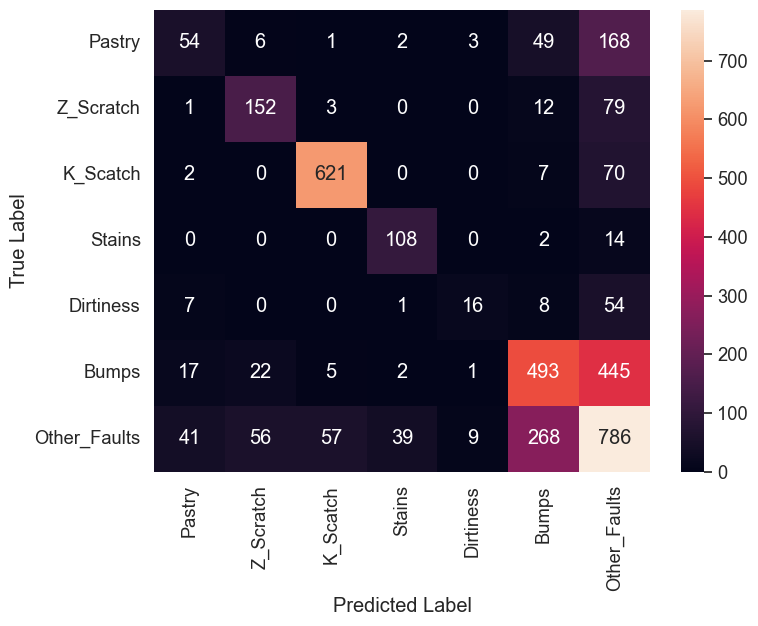

In [74]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [76]:
test_ids = test_df['id']

In [77]:
test_df.drop('id', axis=1, inplace = True)

In [78]:
test_prediction_vot = xgb1.predict_proba(test_df)
test_prediction_vot = pd.DataFrame(test_prediction_vot, columns = y.keys())
submission_vot = pd.concat([test_ids, test_prediction_vot],axis = 1)
submission_vot

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.487073,0.005378,0.004507,0.000818,0.020832,0.156745,0.324647
1,19220,0.214903,0.030344,0.009848,0.001068,0.217551,0.174311,0.351974
2,19221,0.004837,0.035564,0.035223,0.001840,0.009930,0.387728,0.524877
3,19222,0.152862,0.012252,0.002462,0.003660,0.012602,0.356591,0.459570
4,19223,0.004631,0.009138,0.002164,0.003447,0.011132,0.631786,0.337703
...,...,...,...,...,...,...,...,...
12809,32028,0.069637,0.114546,0.008557,0.001189,0.036005,0.224317,0.545748
12810,32029,0.180612,0.008023,0.026030,0.013214,0.120854,0.220695,0.430571
12811,32030,0.000707,0.000818,0.960959,0.000341,0.000754,0.001279,0.035141
12812,32031,0.410468,0.011987,0.019880,0.000873,0.072567,0.138798,0.345428


In [79]:
submission_vot.to_csv('submission.csv', index=False)

#### LightGBM

In [149]:
#     param = {
#         "objective": "multiclass",
#         #"metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "num_class": 7,
#         "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.015),
#         "n_estimators": trial.suggest_int("n_estimators", 850, 920),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.025),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#         "max_depth": trial.suggest_int("max_depth", 4, 7),
#         "num_leaves": trial.suggest_int("num_leaves", 25, 60),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
#     }

In [84]:
weights_lgb = {
            cls: weight for cls, weight in zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        }

In [86]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        #"metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        # "class_weight": {
        #     cls: weight for cls, weight in zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        # },
        
        "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.02),
        "n_estimators": trial.suggest_int("n_estimators", 880, 1300),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.01, 0.55),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.01, 0.55),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.95),
        "subsample": trial.suggest_float("subsample", 0.15, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 75),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)
    
    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    # score = lgbm_classifier.score(X_test, y_test)
    
    y_pred_lgb = lgbm_classifier.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_lgb, multi_class='ovr')
    
    print(f'SCORE: {score}')

    return score

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)


# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50) # n_trials=25

# Get the best parameters after optimization
# Access the best hyperparameters
best_params_lgb = study.best_params
best_score_lgb = study.best_value

print("Best score:", best_score_lgb )
print("Best parameters:", best_params_lgb)

[I 2024-03-23 23:57:16,366] A new study created in memory with name: no-name-38cd2bd5-4163-4c5e-85df-b7250d133bda
[I 2024-03-23 23:57:20,226] Trial 0 finished with value: 0.8904502678548163 and parameters: {'learning_rate': 0.013119941307320988, 'n_estimators': 1280, 'lambda_l1': 0.4052767285781588, 'lambda_l2': 0.3332755814663998, 'max_depth': 3, 'num_leaves': 29, 'colsample_bytree': 0.2435627091261496, 'subsample': 0.8862497239086949, 'min_child_samples': 46}. Best is trial 0 with value: 0.8904502678548163.


SCORE: 0.8904502678548163


[I 2024-03-23 23:57:23,232] Trial 1 finished with value: 0.890521283704767 and parameters: {'learning_rate': 0.0167887983557565, 'n_estimators': 888, 'lambda_l1': 0.533751320167477, 'lambda_l2': 0.4595190260322278, 'max_depth': 3, 'num_leaves': 31, 'colsample_bytree': 0.3375533823900754, 'subsample': 0.408605906515607, 'min_child_samples': 40}. Best is trial 1 with value: 0.890521283704767.


SCORE: 0.890521283704767


[I 2024-03-23 23:57:28,551] Trial 2 finished with value: 0.8875723332592881 and parameters: {'learning_rate': 0.013751395205063273, 'n_estimators': 1002, 'lambda_l1': 0.34040056315008493, 'lambda_l2': 0.08532668475210259, 'max_depth': 4, 'num_leaves': 42, 'colsample_bytree': 0.542052488162777, 'subsample': 0.8173995671840616, 'min_child_samples': 16}. Best is trial 1 with value: 0.890521283704767.


SCORE: 0.8875723332592881


[I 2024-03-23 23:57:33,929] Trial 3 finished with value: 0.8872507317867813 and parameters: {'learning_rate': 0.014656578822549728, 'n_estimators': 1129, 'lambda_l1': 0.03508322286879877, 'lambda_l2': 0.33807422002677673, 'max_depth': 3, 'num_leaves': 23, 'colsample_bytree': 0.91166415294, 'subsample': 0.9707872281133755, 'min_child_samples': 61}. Best is trial 1 with value: 0.890521283704767.


SCORE: 0.8872507317867813


[I 2024-03-23 23:57:36,719] Trial 4 finished with value: 0.8909333308244705 and parameters: {'learning_rate': 0.012350751460907076, 'n_estimators': 921, 'lambda_l1': 0.37948583431656474, 'lambda_l2': 0.24768234661938474, 'max_depth': 3, 'num_leaves': 50, 'colsample_bytree': 0.2257913908364138, 'subsample': 0.9229223417669647, 'min_child_samples': 21}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8909333308244705


[I 2024-03-23 23:57:41,529] Trial 5 finished with value: 0.8877282771215464 and parameters: {'learning_rate': 0.016287745127893802, 'n_estimators': 1011, 'lambda_l1': 0.29083673143601785, 'lambda_l2': 0.30522355084537106, 'max_depth': 3, 'num_leaves': 79, 'colsample_bytree': 0.7813496175208359, 'subsample': 0.9485741003295608, 'min_child_samples': 68}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8877282771215464


[I 2024-03-23 23:57:46,020] Trial 6 finished with value: 0.8874103306359812 and parameters: {'learning_rate': 0.015576899766921937, 'n_estimators': 1268, 'lambda_l1': 0.05778595110803653, 'lambda_l2': 0.1158307457063384, 'max_depth': 3, 'num_leaves': 39, 'colsample_bytree': 0.4915079672671115, 'subsample': 0.3806466770078115, 'min_child_samples': 63}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8874103306359812


[I 2024-03-23 23:57:56,081] Trial 7 finished with value: 0.8840153271087031 and parameters: {'learning_rate': 0.012924286593629482, 'n_estimators': 998, 'lambda_l1': 0.3030558849054542, 'lambda_l2': 0.08609908148637183, 'max_depth': 6, 'num_leaves': 24, 'colsample_bytree': 0.9401652024503879, 'subsample': 0.8064080539021589, 'min_child_samples': 16}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8840153271087031


[I 2024-03-23 23:58:05,682] Trial 8 finished with value: 0.8889779835073713 and parameters: {'learning_rate': 0.009060743288359626, 'n_estimators': 1223, 'lambda_l1': 0.3917029656777133, 'lambda_l2': 0.40366387074213317, 'max_depth': 6, 'num_leaves': 24, 'colsample_bytree': 0.46884929640820444, 'subsample': 0.24848870059636025, 'min_child_samples': 65}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8889779835073713


[I 2024-03-23 23:58:11,720] Trial 9 finished with value: 0.886758321171713 and parameters: {'learning_rate': 0.01585627939510314, 'n_estimators': 1019, 'lambda_l1': 0.044321509154452765, 'lambda_l2': 0.1779304537264576, 'max_depth': 4, 'num_leaves': 64, 'colsample_bytree': 0.6781681035164098, 'subsample': 0.9041308311898776, 'min_child_samples': 36}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.886758321171713


[I 2024-03-23 23:58:16,891] Trial 10 finished with value: 0.8872885452886863 and parameters: {'learning_rate': 0.019396501986534257, 'n_estimators': 882, 'lambda_l1': 0.17615487418314174, 'lambda_l2': 0.21409383698120937, 'max_depth': 5, 'num_leaves': 57, 'colsample_bytree': 0.21134511193503847, 'subsample': 0.6715278865784622, 'min_child_samples': 5}. Best is trial 4 with value: 0.8909333308244705.


SCORE: 0.8872885452886863


[I 2024-03-23 23:58:20,995] Trial 11 finished with value: 0.8912647269816596 and parameters: {'learning_rate': 0.010381082692511949, 'n_estimators': 886, 'lambda_l1': 0.5207372487858053, 'lambda_l2': 0.5078201987699916, 'max_depth': 4, 'num_leaves': 48, 'colsample_bytree': 0.34962156441266096, 'subsample': 0.5130454597883323, 'min_child_samples': 36}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8912647269816596


[I 2024-03-23 23:58:25,337] Trial 12 finished with value: 0.8910432028812751 and parameters: {'learning_rate': 0.010454292491483805, 'n_estimators': 940, 'lambda_l1': 0.5236147226351502, 'lambda_l2': 0.5423638249050216, 'max_depth': 4, 'num_leaves': 50, 'colsample_bytree': 0.37679093980300576, 'subsample': 0.5919018570902551, 'min_child_samples': 27}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8910432028812751


[I 2024-03-23 23:58:31,739] Trial 13 finished with value: 0.8902605069823533 and parameters: {'learning_rate': 0.009922538261822926, 'n_estimators': 945, 'lambda_l1': 0.545685100900402, 'lambda_l2': 0.5496557168664378, 'max_depth': 5, 'num_leaves': 66, 'colsample_bytree': 0.381166199735255, 'subsample': 0.5725225845692247, 'min_child_samples': 26}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8902605069823533


[I 2024-03-23 23:58:36,900] Trial 14 finished with value: 0.8900696376982375 and parameters: {'learning_rate': 0.011262413534643785, 'n_estimators': 1089, 'lambda_l1': 0.4712277615368029, 'lambda_l2': 0.5478491742550554, 'max_depth': 4, 'num_leaves': 48, 'colsample_bytree': 0.3845100896845504, 'subsample': 0.5612627144099853, 'min_child_samples': 31}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8900696376982375


[I 2024-03-23 23:58:44,001] Trial 15 finished with value: 0.8893403667458962 and parameters: {'learning_rate': 0.010697045654236133, 'n_estimators': 961, 'lambda_l1': 0.4643666029811268, 'lambda_l2': 0.4701593075382155, 'max_depth': 5, 'num_leaves': 59, 'colsample_bytree': 0.6288964694862942, 'subsample': 0.4276369049606248, 'min_child_samples': 49}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8893403667458962


[I 2024-03-23 23:58:49,864] Trial 16 finished with value: 0.8898642068225603 and parameters: {'learning_rate': 0.011524536872959852, 'n_estimators': 1069, 'lambda_l1': 0.17723041087056496, 'lambda_l2': 0.46592892363341126, 'max_depth': 4, 'num_leaves': 40, 'colsample_bytree': 0.32691609674487637, 'subsample': 0.6920612142067827, 'min_child_samples': 2}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8898642068225603


[I 2024-03-23 23:58:55,870] Trial 17 finished with value: 0.8904668630221454 and parameters: {'learning_rate': 0.009081175532186929, 'n_estimators': 1136, 'lambda_l1': 0.48410583789152406, 'lambda_l2': 0.386440390506897, 'max_depth': 4, 'num_leaves': 74, 'colsample_bytree': 0.44025480144343787, 'subsample': 0.18085909124730082, 'min_child_samples': 51}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8904668630221454


[I 2024-03-23 23:59:01,649] Trial 18 finished with value: 0.8869594796111111 and parameters: {'learning_rate': 0.018616549569606705, 'n_estimators': 928, 'lambda_l1': 0.21357782421384436, 'lambda_l2': 0.012246143481631888, 'max_depth': 5, 'num_leaves': 56, 'colsample_bytree': 0.3060155254706743, 'subsample': 0.499479385262874, 'min_child_samples': 31}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8869594796111111


[I 2024-03-23 23:59:07,328] Trial 19 finished with value: 0.8900139740055429 and parameters: {'learning_rate': 0.010521454612828586, 'n_estimators': 969, 'lambda_l1': 0.4330621585855032, 'lambda_l2': 0.5081455402719848, 'max_depth': 4, 'num_leaves': 46, 'colsample_bytree': 0.5736537683988285, 'subsample': 0.6717738425516955, 'min_child_samples': 11}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8900139740055429


[I 2024-03-23 23:59:15,403] Trial 20 finished with value: 0.8874519901147009 and parameters: {'learning_rate': 0.012037177666252272, 'n_estimators': 1042, 'lambda_l1': 0.49707737595086393, 'lambda_l2': 0.40287012184634463, 'max_depth': 5, 'num_leaves': 34, 'colsample_bytree': 0.723572480004051, 'subsample': 0.7409495079282322, 'min_child_samples': 75}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8874519901147009


[I 2024-03-23 23:59:18,865] Trial 21 finished with value: 0.8912084369092715 and parameters: {'learning_rate': 0.01228218142631475, 'n_estimators': 919, 'lambda_l1': 0.3605456792952064, 'lambda_l2': 0.24045326488445257, 'max_depth': 3, 'num_leaves': 52, 'colsample_bytree': 0.25079630567689015, 'subsample': 0.47440199985814185, 'min_child_samples': 24}. Best is trial 11 with value: 0.8912647269816596.


SCORE: 0.8912084369092715


[I 2024-03-23 23:59:23,096] Trial 22 finished with value: 0.8917150434386463 and parameters: {'learning_rate': 0.01000919712429201, 'n_estimators': 910, 'lambda_l1': 0.5497182601698165, 'lambda_l2': 0.25257653177794526, 'max_depth': 4, 'num_leaves': 51, 'colsample_bytree': 0.27787737584982924, 'subsample': 0.31764797901673625, 'min_child_samples': 25}. Best is trial 22 with value: 0.8917150434386463.


SCORE: 0.8917150434386463


[I 2024-03-23 23:59:27,176] Trial 23 finished with value: 0.8913363061235449 and parameters: {'learning_rate': 0.00980238643810666, 'n_estimators': 903, 'lambda_l1': 0.440304570504963, 'lambda_l2': 0.25461626149305117, 'max_depth': 4, 'num_leaves': 53, 'colsample_bytree': 0.26608912442711236, 'subsample': 0.31021307740923315, 'min_child_samples': 40}. Best is trial 22 with value: 0.8917150434386463.


SCORE: 0.8913363061235449


[I 2024-03-23 23:59:31,604] Trial 24 finished with value: 0.8918270309846753 and parameters: {'learning_rate': 0.009747090998794613, 'n_estimators': 880, 'lambda_l1': 0.43728039485804304, 'lambda_l2': 0.2749518677737895, 'max_depth': 4, 'num_leaves': 63, 'colsample_bytree': 0.29211638271442464, 'subsample': 0.3104342202377112, 'min_child_samples': 41}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8918270309846753


[I 2024-03-23 23:59:36,368] Trial 25 finished with value: 0.8916934820187511 and parameters: {'learning_rate': 0.009617697953567723, 'n_estimators': 979, 'lambda_l1': 0.4408971610423355, 'lambda_l2': 0.1773933345317129, 'max_depth': 4, 'num_leaves': 67, 'colsample_bytree': 0.28197159648167486, 'subsample': 0.31694697340941386, 'min_child_samples': 44}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8916934820187511


[I 2024-03-23 23:59:42,661] Trial 26 finished with value: 0.8904822366815762 and parameters: {'learning_rate': 0.009024815557053242, 'n_estimators': 977, 'lambda_l1': 0.4279750659731146, 'lambda_l2': 0.19443641616108254, 'max_depth': 5, 'num_leaves': 69, 'colsample_bytree': 0.4187498188195597, 'subsample': 0.29619606616824984, 'min_child_samples': 56}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8904822366815762


[I 2024-03-23 23:59:48,238] Trial 27 finished with value: 0.8901453964911737 and parameters: {'learning_rate': 0.011357298247767532, 'n_estimators': 1167, 'lambda_l1': 0.24298578369419355, 'lambda_l2': 0.1506392953287904, 'max_depth': 4, 'num_leaves': 64, 'colsample_bytree': 0.29500252933333226, 'subsample': 0.15291997353338835, 'min_child_samples': 44}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8901453964911737


[I 2024-03-23 23:59:54,117] Trial 28 finished with value: 0.8901381679074908 and parameters: {'learning_rate': 0.009782300548879465, 'n_estimators': 967, 'lambda_l1': 0.33078826423309327, 'lambda_l2': 0.2877695935178637, 'max_depth': 4, 'num_leaves': 71, 'colsample_bytree': 0.5323271921114001, 'subsample': 0.316833043263424, 'min_child_samples': 32}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8901381679074908


[I 2024-03-23 23:59:59,660] Trial 29 finished with value: 0.890050788191003 and parameters: {'learning_rate': 0.013734169619623513, 'n_estimators': 1040, 'lambda_l1': 0.4029312893015913, 'lambda_l2': 0.3390924225944745, 'max_depth': 5, 'num_leaves': 61, 'colsample_bytree': 0.20551576067156146, 'subsample': 0.2288426713088898, 'min_child_samples': 46}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.890050788191003


[I 2024-03-24 00:00:03,741] Trial 30 finished with value: 0.890949220858885 and parameters: {'learning_rate': 0.01114652488118634, 'n_estimators': 909, 'lambda_l1': 0.5001070780869308, 'lambda_l2': 0.14893431119291295, 'max_depth': 3, 'num_leaves': 80, 'colsample_bytree': 0.27554671388946617, 'subsample': 0.36121842259576487, 'min_child_samples': 54}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.890949220858885


[I 2024-03-24 00:00:08,777] Trial 31 finished with value: 0.8912937245630717 and parameters: {'learning_rate': 0.009709555208247971, 'n_estimators': 899, 'lambda_l1': 0.4384147270063771, 'lambda_l2': 0.25447685501853606, 'max_depth': 4, 'num_leaves': 54, 'colsample_bytree': 0.2690962144835153, 'subsample': 0.31721337717263237, 'min_child_samples': 42}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8912937245630717


[I 2024-03-24 00:00:13,989] Trial 32 finished with value: 0.8911183844267718 and parameters: {'learning_rate': 0.009584764193939787, 'n_estimators': 940, 'lambda_l1': 0.44979446554094776, 'lambda_l2': 0.2871814190684208, 'max_depth': 4, 'num_leaves': 61, 'colsample_bytree': 0.3145878518718638, 'subsample': 0.24081786985531156, 'min_child_samples': 37}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8911183844267718


[I 2024-03-24 00:00:18,352] Trial 33 finished with value: 0.8900132184250057 and parameters: {'learning_rate': 0.017794670894704268, 'n_estimators': 880, 'lambda_l1': 0.4161155691962997, 'lambda_l2': 0.21095083468776296, 'max_depth': 4, 'num_leaves': 43, 'colsample_bytree': 0.26441631611981603, 'subsample': 0.417092664814799, 'min_child_samples': 40}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8900132184250057


[I 2024-03-24 00:00:23,753] Trial 34 finished with value: 0.8906203948823677 and parameters: {'learning_rate': 0.010122022937905956, 'n_estimators': 912, 'lambda_l1': 0.3486440918673542, 'lambda_l2': 0.3192813885421672, 'max_depth': 4, 'num_leaves': 74, 'colsample_bytree': 0.41367492041638276, 'subsample': 0.3477526838629741, 'min_child_samples': 49}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8906203948823677


[I 2024-03-24 00:00:28,653] Trial 35 finished with value: 0.8900520333294654 and parameters: {'learning_rate': 0.012928659444404807, 'n_estimators': 992, 'lambda_l1': 0.5104599260859904, 'lambda_l2': 0.36764791972327165, 'max_depth': 4, 'num_leaves': 67, 'colsample_bytree': 0.33869634253113906, 'subsample': 0.28439810124860027, 'min_child_samples': 20}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8900520333294654


[I 2024-03-24 00:00:33,678] Trial 36 finished with value: 0.8889828135153731 and parameters: {'learning_rate': 0.011932596210056125, 'n_estimators': 951, 'lambda_l1': 0.36985806188577497, 'lambda_l2': 0.2562733845201281, 'max_depth': 3, 'num_leaves': 55, 'colsample_bytree': 0.8402572651257039, 'subsample': 0.2114749551424439, 'min_child_samples': 57}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8889828135153731


[I 2024-03-24 00:00:37,263] Trial 37 finished with value: 0.891240293374611 and parameters: {'learning_rate': 0.01090447359124808, 'n_estimators': 906, 'lambda_l1': 0.5489062340539892, 'lambda_l2': 0.13733067167333246, 'max_depth': 3, 'num_leaves': 61, 'colsample_bytree': 0.23766770868884843, 'subsample': 0.44285265350209213, 'min_child_samples': 42}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.891240293374611


[I 2024-03-24 00:00:41,605] Trial 38 finished with value: 0.8898118788081254 and parameters: {'learning_rate': 0.014131767432824967, 'n_estimators': 929, 'lambda_l1': 0.3197775501159128, 'lambda_l2': 0.22353101733133235, 'max_depth': 4, 'num_leaves': 34, 'colsample_bytree': 0.35842195817465167, 'subsample': 0.27246492122211435, 'min_child_samples': 34}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8898118788081254


[I 2024-03-24 00:00:45,919] Trial 39 finished with value: 0.8901850766081223 and parameters: {'learning_rate': 0.009328933314556021, 'n_estimators': 983, 'lambda_l1': 0.1113554269811437, 'lambda_l2': 0.1734502582098507, 'max_depth': 3, 'num_leaves': 74, 'colsample_bytree': 0.4943136998336046, 'subsample': 0.38605965968471107, 'min_child_samples': 39}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8901850766081223


[I 2024-03-24 00:00:50,231] Trial 40 finished with value: 0.8913289871538509 and parameters: {'learning_rate': 0.010087192837228311, 'n_estimators': 1027, 'lambda_l1': 0.27170177134643225, 'lambda_l2': 0.08024060127518835, 'max_depth': 4, 'num_leaves': 44, 'colsample_bytree': 0.20108750884456517, 'subsample': 0.3312903883822047, 'min_child_samples': 29}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8913289871538509


[I 2024-03-24 00:00:55,298] Trial 41 finished with value: 0.8907354084990315 and parameters: {'learning_rate': 0.010041420286404134, 'n_estimators': 1023, 'lambda_l1': 0.25303648709509097, 'lambda_l2': 0.03470713066686179, 'max_depth': 4, 'num_leaves': 36, 'colsample_bytree': 0.22124223499632084, 'subsample': 0.34556438070015877, 'min_child_samples': 28}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8907354084990315


[I 2024-03-24 00:00:59,506] Trial 42 finished with value: 0.8901229798995899 and parameters: {'learning_rate': 0.01486229942480871, 'n_estimators': 1047, 'lambda_l1': 0.2867747611141118, 'lambda_l2': 0.09000170565614023, 'max_depth': 4, 'num_leaves': 46, 'colsample_bytree': 0.20362469736010916, 'subsample': 0.19046686083413109, 'min_child_samples': 22}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8901229798995899


[I 2024-03-24 00:01:04,502] Trial 43 finished with value: 0.8913469684024131 and parameters: {'learning_rate': 0.009553831954851074, 'n_estimators': 1004, 'lambda_l1': 0.3836277171798857, 'lambda_l2': 0.30279028707135436, 'max_depth': 4, 'num_leaves': 44, 'colsample_bytree': 0.2926169246253453, 'subsample': 0.261554467713783, 'min_child_samples': 16}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8913469684024131


[I 2024-03-24 00:01:10,245] Trial 44 finished with value: 0.8912253229551805 and parameters: {'learning_rate': 0.009470760361207165, 'n_estimators': 1004, 'lambda_l1': 0.39363571855473334, 'lambda_l2': 0.35238405616903656, 'max_depth': 4, 'num_leaves': 52, 'colsample_bytree': 0.28602994241200913, 'subsample': 0.2734392193637912, 'min_child_samples': 13}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8912253229551805


[I 2024-03-24 00:01:14,620] Trial 45 finished with value: 0.8907954692647159 and parameters: {'learning_rate': 0.010832397516597217, 'n_estimators': 896, 'lambda_l1': 0.45815507319824633, 'lambda_l2': 0.2996332131082077, 'max_depth': 4, 'num_leaves': 29, 'colsample_bytree': 0.321756013459975, 'subsample': 0.3864733142376937, 'min_child_samples': 17}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8907954692647159


[I 2024-03-24 00:01:20,399] Trial 46 finished with value: 0.8901606497737587 and parameters: {'learning_rate': 0.01173679625826893, 'n_estimators': 937, 'lambda_l1': 0.3816134047768189, 'lambda_l2': 0.2709652987616961, 'max_depth': 5, 'num_leaves': 58, 'colsample_bytree': 0.2479993938294415, 'subsample': 0.24438220514524855, 'min_child_samples': 8}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8901606497737587


[I 2024-03-24 00:01:28,251] Trial 47 finished with value: 0.8899773933371892 and parameters: {'learning_rate': 0.01038781655178225, 'n_estimators': 918, 'lambda_l1': 0.4812502288267172, 'lambda_l2': 0.3191831106885331, 'max_depth': 6, 'num_leaves': 40, 'colsample_bytree': 0.391779482978041, 'subsample': 0.15357386778059723, 'min_child_samples': 47}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8899773933371892


[I 2024-03-24 00:01:33,592] Trial 48 finished with value: 0.8893021583672386 and parameters: {'learning_rate': 0.012496128607186414, 'n_estimators': 957, 'lambda_l1': 0.4086145557545452, 'lambda_l2': 0.22796239166556176, 'max_depth': 4, 'num_leaves': 64, 'colsample_bytree': 0.44772696236342935, 'subsample': 0.4741984402372972, 'min_child_samples': 19}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8893021583672386


[I 2024-03-24 00:01:37,239] Trial 49 finished with value: 0.8905536615534732 and parameters: {'learning_rate': 0.009023921939722694, 'n_estimators': 892, 'lambda_l1': 0.525635903103074, 'lambda_l2': 0.188797532033474, 'max_depth': 3, 'num_leaves': 52, 'colsample_bytree': 0.351330561637057, 'subsample': 0.20009703801361145, 'min_child_samples': 34}. Best is trial 24 with value: 0.8918270309846753.


SCORE: 0.8905536615534732
Best score: 0.8918270309846753
Best parameters: {'learning_rate': 0.009747090998794613, 'n_estimators': 880, 'lambda_l1': 0.43728039485804304, 'lambda_l2': 0.2749518677737895, 'max_depth': 4, 'num_leaves': 63, 'colsample_bytree': 0.29211638271442464, 'subsample': 0.3104342202377112, 'min_child_samples': 41}


In [87]:
print('Best parameters from Optuna for LightGBM model are: ')
print(best_params_lgb)

Best parameters from Optuna for LightGBM model are: 
{'learning_rate': 0.009747090998794613, 'n_estimators': 880, 'lambda_l1': 0.43728039485804304, 'lambda_l2': 0.2749518677737895, 'max_depth': 4, 'num_leaves': 63, 'colsample_bytree': 0.29211638271442464, 'subsample': 0.3104342202377112, 'min_child_samples': 41}


In [88]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params_lgb1 = {
         "objective": "multiclass",
        #"metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        # "class_weight": {
        #     cls: weight for cls, weight in zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        # },
    
     'learning_rate': 0.009747090998794613, 
    'n_estimators': 880, 
    'lambda_l1': 0.43728039485804304, 
    'lambda_l2': 0.2749518677737895, 
    'max_depth': 4, 
    'num_leaves': 63, 
    'colsample_bytree': 0.29211638271442464, 
    'subsample': 0.3104342202377112, 
    'min_child_samples': 41}

In [89]:
# Training the model again with the selected features

lgb1 = LGBMClassifier(**best_params_lgb1)

lgb1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.29211638271442464,
               lambda_l1=0.43728039485804304, lambda_l2=0.2749518677737895,
               learning_rate=0.009747090998794613, max_depth=4,
               min_child_samples=41, n_estimators=880, num_class=7,
               num_leaves=63, objective='multiclass', random_state=42,
               subsample=0.3104342202377112, verbosity=-1)

In [90]:
# Get the predicted probabilities for the positive class
y_prob_lgb = lgb1.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_lgb = roc_auc_score(y_test, y_prob_lgb, multi_class='ovo')
roc_auc_ovr_lgb = roc_auc_score(y_test, y_prob_lgb, multi_class='ovr')

print("ROC-AUC-OVO Score LGB:", roc_auc_ovo_lgb)
print("ROC-AUC-OVR Score LGB:", roc_auc_ovr_lgb)

ROC-AUC-OVO Score LGB: 0.9031524649530427
ROC-AUC-OVR Score LGB: 0.8918270309846753


In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob_lgb, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.41      0.17      0.24       283
   Z_Scratch       0.63      0.63      0.63       247
    K_Scatch       0.91      0.89      0.90       700
      Stains       0.69      0.88      0.77       124
   Dirtiness       0.53      0.20      0.29        86
       Bumps       0.58      0.49      0.53       985
Other_Faults       0.48      0.62      0.54      1256

    accuracy                           0.60      3681
   macro avg       0.60      0.55      0.56      3681
weighted avg       0.60      0.60      0.59      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

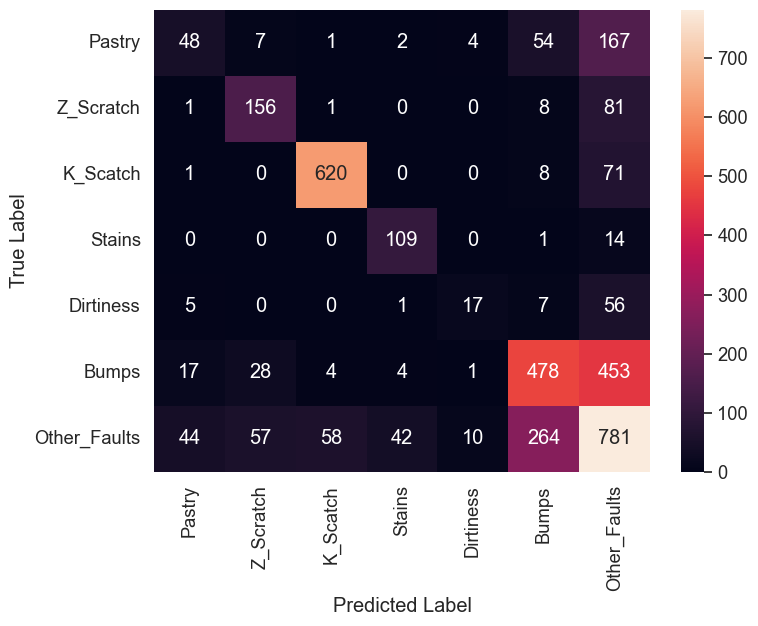

In [92]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob_lgb, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Catboost

In [98]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "verbose": False,
        "random_seed": 42,
        
        # "class_weights": {
        #     cls: weight for cls, weight in zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
        # },
        
        "leaf_estimation_method": "Newton",  # Optional: faster leaf calculation
        "boosting_type": "Plain",  # Optional: change boosting type to Plain for better control
        "bootstrap_type": "Bayesian",  # Optional: change bootstrap type for better control
        #"subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Optional: tune subsample
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),  # Optional: tune leaf estimation iterations
        
        "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.02),
        "iterations": trial.suggest_int("iterations", 800, 1000),
        "depth": trial.suggest_int("depth", 3, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.2, 1.0),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    cat_classifier = CatBoostClassifier(**param)
    
    # Fit the classifier on the training data
    cat_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    #score = lgbm_classifier.score(X_test, y_test)
    
    y_pred_cat = cat_classifier.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_cat, multi_class='ovr')
    
    print(f'SCORE: {score}')

    return score

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)


# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

# Get the best parameters after optimization
# Access the best hyperparameters
best_params_cat = study.best_params
best_score_cat = study.best_value

print("Best score:", best_score_cat)
print("Best parameters:", best_params_cat)

In [94]:
print('Best parameters from Optuna for CatBoost model are: ')
print(best_params_cat)

Best parameters from Optuna for CatBoost model are: 
{'leaf_estimation_iterations': 4, 'learning_rate': 0.019465457268191173, 'iterations': 910, 'depth': 5, 'l2_leaf_reg': 3.4120903836159138, 'bagging_temperature': 0.20167211877267657}


In [95]:
# If you do not run the optuna function above, here are the best parameters that the optimizer gave:

best_params_cat1 = {
         "verbose": False,
        "random_seed": 42,
    # "class_weights": {
    #         cls: weight for cls, weight in zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
    #     },
    
   'leaf_estimation_iterations': 4, 
    'learning_rate': 0.019465457268191173, 
    'iterations': 910, 
    'depth': 5,
    'l2_leaf_reg': 3.4120903836159138,
    'bagging_temperature': 0.20167211877267657}

In [96]:
# Training the model again with the selected features

cat1 = CatBoostClassifier(**best_params_cat1)

cat1.fit(X_train, y_train)

In [97]:
# Get the predicted probabilities for the positive class
y_prob_cat = cat1.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_cat = roc_auc_score(y_test, y_prob_cat, multi_class='ovo')
roc_auc_ovr_cat = roc_auc_score(y_test, y_prob_cat, multi_class='ovr')

print("ROC-AUC-OVO Score CAT:", roc_auc_ovo_cat)
print("ROC-AUC-OVR Score CAT:", roc_auc_ovr_cat)

ROC-AUC-OVO Score CAT: 0.9015129430930153
ROC-AUC-OVR Score CAT: 0.8912402272386863


#### Voting Regressor Model

In [99]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the weighted ensemble
    
    obj_estimators = [
        ('LGBM', LGBMClassifier(**best_params_lgb1)),
        ('XGB', XGBClassifier(**best_params)),
        ('CAT', CatBoostClassifier(**best_params_cat1))
    ]
    
    voting_classifier = VotingClassifier(
        estimators=obj_estimators,
        voting='soft',
        weights=[
            trial.suggest_float('LGBM_Weight', 0.00, 10.00),
            trial.suggest_float('XGB_Weight', 0.00, 10.00),
            trial.suggest_float('CAT_Weight', 0.00, 10.00),
        ],
    )
    
    voting_classifier.fit(X_train, y_train)
    
    predict_probs = voting_classifier.predict_proba(X_test)
    
    auc_score = roc_auc_score(y_test, predict_probs, multi_class='ovr')

    return auc_score

# Set up the sampler for Optuna optimization
weight_sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
weight_study = optuna.create_study(direction="maximize", sampler=weight_sampler)

# Run the optimization process
weight_study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

# Get the best parameters after optimization
weight_best_params = weight_study.best_params
    
print(f'BEST WEIGHTS: {weight_best_params}')

[I 2024-03-24 00:24:02,248] A new study created in memory with name: no-name-3b6a60a6-5df5-43de-b278-8316fae3369f
[I 2024-03-24 00:24:34,396] Trial 0 finished with value: 0.8930667129192662 and parameters: {'LGBM_Weight': 3.745401188473625, 'XGB_Weight': 9.50714306409916, 'CAT_Weight': 7.319939418114051}. Best is trial 0 with value: 0.8930667129192662.
[I 2024-03-24 00:25:08,877] Trial 1 finished with value: 0.8926776275220446 and parameters: {'LGBM_Weight': 5.986584841970366, 'XGB_Weight': 1.5601864044243652, 'CAT_Weight': 1.5599452033620265}. Best is trial 0 with value: 0.8930667129192662.
[I 2024-03-24 00:25:45,211] Trial 2 finished with value: 0.893012837118688 and parameters: {'LGBM_Weight': 0.5808361216819946, 'XGB_Weight': 8.661761457749352, 'CAT_Weight': 6.011150117432088}. Best is trial 0 with value: 0.8930667129192662.
[I 2024-03-24 00:26:22,142] Trial 3 finished with value: 0.892530784661858 and parameters: {'LGBM_Weight': 7.080725777960454, 'XGB_Weight': 0.20584494295802447

BEST WEIGHTS: {'LGBM_Weight': 6.024479947995602, 'XGB_Weight': 8.980865827978402, 'CAT_Weight': 5.22711558066773}


In [101]:
# If you do not run the optuna function above, here are the best weights that the optimizer gave:
weight_best_params = {'LGBM_Weight': 6.024479947995602, 'XGB_Weight': 8.980865827978402, 'CAT_Weight': 5.22711558066773}

In [100]:
print('Best weights from Optuna for the voting model are: ')
print(weight_best_params)

Best weights from Optuna for the voting model are: 
{'LGBM_Weight': 6.024479947995602, 'XGB_Weight': 8.980865827978402, 'CAT_Weight': 5.22711558066773}


In [102]:
obj_estimators = [
        ('LGBM', LGBMClassifier(**best_params_lgb1)),
        ('XGB', XGBClassifier(**best_params)),
        ('CAT', CatBoostClassifier(**best_params_cat1))
    ]

In [103]:
voting_classifier = VotingClassifier(
    estimators=obj_estimators,
    voting='soft',
    weights=[
        6.024479947995602,
        8.980865827978402,
        5.22711558066773,
    ],
)

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(colsample_bytree=0.29211638271442464,
                                             lambda_l1=0.43728039485804304,
                                             lambda_l2=0.2749518677737895,
                                             learning_rate=0.009747090998794613,
                                             max_depth=4, min_child_samples=41,
                                             n_estimators=880, num_class=7,
                                             num_leaves=63,
                                             objective='multiclass',
                                             random_state=42,
                                             subsample=0.3104342202377112,
                                             verbosity=-1)),
                             ('XGB',
                              X...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=943, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x000002695E56F810>)],
                 voting='soft',
                 weights=[6.024479947995602, 8.980865827978402,
                          5.22711558066773])

In [104]:
# Get the predicted probabilities for the positive class
y_prob_vot = voting_classifier.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_vot = roc_auc_score(y_test, y_prob_vot, multi_class='ovo')
roc_auc_ovr_vot = roc_auc_score(y_test, y_prob_vot, multi_class='ovr')
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovo_vot)
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovr_vot)

ROC-AUC-VOT-OVO Score: 0.9037556456705751
ROC-AUC-VOT-OVO Score: 0.893111929377994


#### Stacking Classifier Model

In [93]:
# Define the base estimators
base_estimators = [
    ('LGBM', LGBMClassifier(**best_params_lgb1)),
    ('XGB', XGBClassifier(**best_params)),
    ('CAT', CatBoostClassifier(**best_params_cat1))
]

# Initialize the stacking classifier with the base estimators and meta-estimator
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression()  # meta-estimator here
)

# Fit the stacking classifier
stacking_classifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('LGBM',
                                LGBMClassifier(colsample_bytree=0.22216512167100838,
                                               lambda_l1=0.51579494580044,
                                               lambda_l2=0.41876546915108137,
                                               learning_rate=0.011451844520852525,
                                               max_depth=4,
                                               min_child_samples=71,
                                               n_estimators=892, num_class=7,
                                               num_leaves=65,
                                               objective='multiclass',
                                               random_state=42,
                                               subsample=0.6364183173814645,
                                               verbosity=-1)),
                               ('XGB',
                                X...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=893, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('CAT',
                                <catboost.core.CatBoostClassifier object at 0x0000012DA560EC10>)],
                   final_estimator=LogisticRegression())

In [94]:
# Get the predicted probabilities for the positive class
y_prob_stack = stacking_classifier.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_sta = roc_auc_score(y_test, y_prob_stack, multi_class='ovo')
roc_auc_ovr_sta = roc_auc_score(y_test, y_prob_stack, multi_class='ovr')
print("ROC-AUC-STA-OVO Score:", roc_auc_ovo_sta)
print("ROC-AUC-STA-OVR Score:", roc_auc_ovr_sta)

ROC-AUC-STA-OVO Score: 0.8924392807563061
ROC-AUC-STA-OVR Score: 0.8829569763995434


### Comparng the Models

In [95]:
print('Xgboost {}'.format(roc_auc_ovr))
print('LightGBM {}'.format(roc_auc_ovr_lgb))
print('Catboost {}'.format(roc_auc_ovr_cat))
print('Voting {}'.format(roc_auc_ovr_vot))
print('Stacking {}'.format(roc_auc_ovr_sta))

Xgboost 0.8927915641513708
LightGBM 0.8922672053091595
Catboost 0.8914519991487911
Voting 0.8934236947924807
Stacking 0.8829569763995434


Based on ROC AUC Score (Receiver Operating Characteristic Area Under the Curve), the voting model performs the best. We will use this model to make predictions

### Classification Report & Confusion Matrix

In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob_vot, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.42      0.17      0.24       283
   Z_Scratch       0.63      0.62      0.63       247
    K_Scatch       0.91      0.89      0.90       700
      Stains       0.69      0.86      0.77       124
   Dirtiness       0.57      0.19      0.28        86
       Bumps       0.58      0.49      0.53       985
Other_Faults       0.48      0.62      0.54      1256

    accuracy                           0.60      3681
   macro avg       0.61      0.55      0.56      3681
weighted avg       0.60      0.60      0.59      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

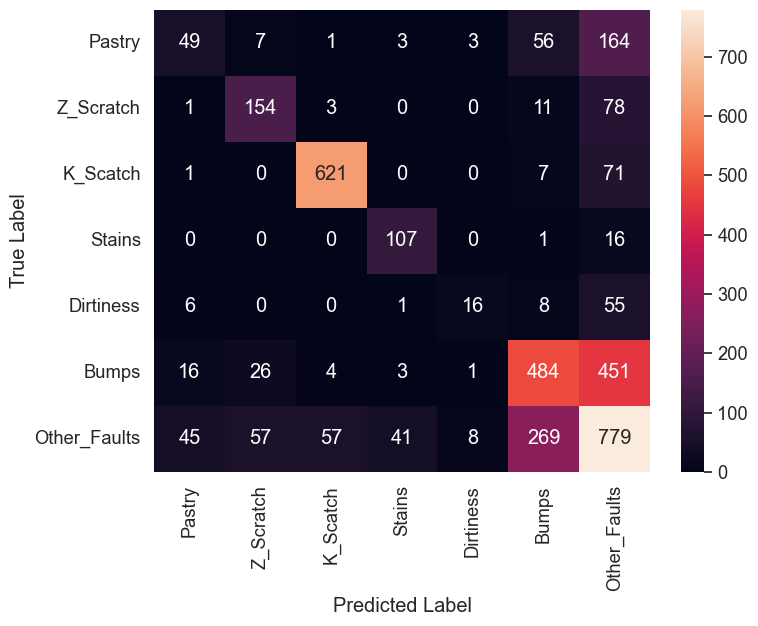

In [106]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob_vot, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [107]:
df_train

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19214,749,757,143210,143219,17,4,4,2193,122,140,1360,0,0,50,0.8950,0.1500,0.8571,0.0044,1.0000,0.8000,0.0,1.2305,0.7782,0.6021,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19215,723,735,2488529,2488541,231,17,26,27135,104,133,1652,1,0,70,0.9243,0.3254,0.2778,0.0065,0.7333,0.9216,1.0,2.3636,1.0414,1.4150,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19216,6,31,1578055,1578129,780,114,98,71112,41,94,1358,0,1,200,0.0148,0.4331,0.2281,0.0199,0.1862,0.9554,1.0,2.8921,1.4314,1.8692,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19217,9,18,1713172,1713184,126,13,26,14808,88,132,1692,1,0,60,0.0192,0.2361,0.0390,0.0068,0.7692,1.0000,1.0,2.1004,1.0414,1.4150,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


In [129]:
original = pd.read_csv('PlaygroundS4E3Original.csv',low_memory=False)

In [130]:
data = pd.concat([df_train,original]).drop('id',axis=1).drop_duplicates()
data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [131]:
data.shape

(20342, 34)

In [132]:
# Creating a function for feature engineering

def feature_engineering(df):
    """
    This function is created to make the feature engineering process of this dataset
    """
    # Calculating the X_distance from X_Maximum and X_Minimum
    df['X_distance'] = df['X_Maximum'] - df['X_Minimum']
    
    # Calculating the Y_distance from Y_Maximum and Y_Minimum
    df['Y_distance'] = df['Y_Maximum'] - df['Y_Minimum']
    
    # Calculating the difference of Maximum_of_Luminosity and Minimum_of_Luminosity
    df['Color_contrast'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']
    
    # Calculating the Density
    df['Density'] = df['Pixels_Areas'] / (df['X_Perimeter'] + df['Y_Perimeter'])
    
    return df

In [135]:
total_data = pd.concat([data, df_test.drop('id', axis=1)])

In [ ]:
data

In [136]:
# Calculating the feature engineered columns

total_data = feature_engineering(total_data)

In [137]:
# Defining columns to scale (Excluding cat_features)

scale_cols = features.copy()
for f in cat_features:
    scale_cols.remove(f)

In [ ]:
test_df 

In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob_vot, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.42      0.17      0.24       283
   Z_Scratch       0.63      0.62      0.63       247
    K_Scatch       0.91      0.89      0.90       700
      Stains       0.69      0.86      0.77       124
   Dirtiness       0.57      0.19      0.28        86
       Bumps       0.58      0.49      0.53       985
Other_Faults       0.48      0.62      0.54      1256

    accuracy                           0.60      3681
   macro avg       0.61      0.55      0.56      3681
weighted avg       0.60      0.60      0.59      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

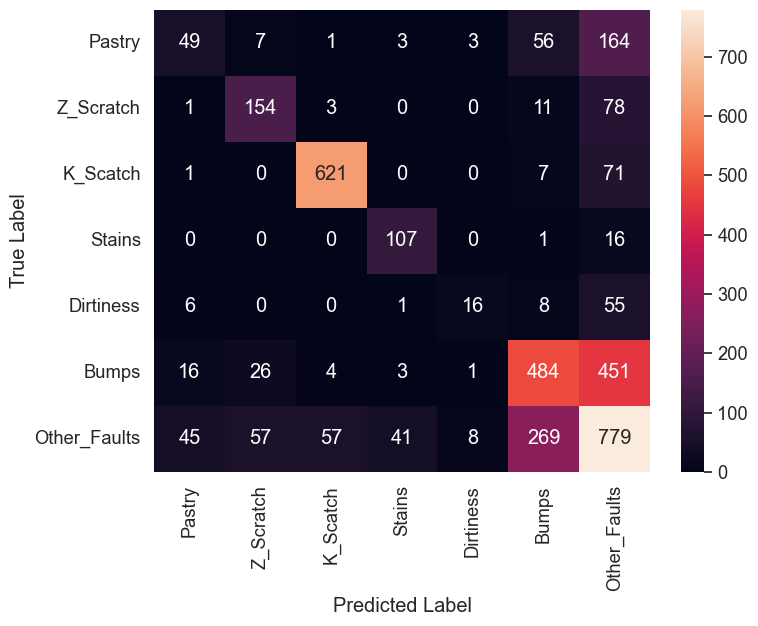

In [106]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob_vot, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [138]:
total_data

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,X_distance,Y_distance,Color_contrast,Density
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,5,27,1.230769
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,22,41,5.851351
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,153,68,112,10.122667
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,27,20,4.666667
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20,45,29,3.748201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,1101,1116,447943,447992,313,32,37,21603,79,103,1353,0,1,70,0.2853,0.3050,0.2339,0.0126,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,49,24,4.536232
12810,1289,1306,3149494,3149542,59,9,18,5249,113,141,1362,0,1,40,0.0106,0.2778,0.2778,0.0052,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,48,28,2.185185
12811,41,210,1587535,1587191,16584,796,522,1858162,24,143,1400,0,1,40,0.0557,0.5644,0.9371,0.1236,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169,-344,119,12.582701
12812,1329,1340,702237,702267,386,43,34,36875,66,124,1364,0,1,40,0.0133,0.1814,0.1539,0.0095,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,30,58,5.012987


In [139]:
# Spliting train and test df after processing

# Train df
train_df_ = total_data[:data.shape[0]]

# Test df
test_df_ = total_data[data.shape[0]:].dropna(axis=1)

In [140]:
# Scaling the train and thest sets using StandardScaler
scaler = StandardScaler()
train_df_.loc[:, scale_cols] = scaler.fit_transform(train_df_[scale_cols])
test_df_.loc[:, scale_cols] = scaler.transform(test_df_[scale_cols])

C:\Users\Admin\AppData\Local\Temp\ipykernel_4992\1046280848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_.loc[:, scale_cols] = scaler.fit_transform(train_df_[scale_cols])


In [141]:
X_comb = train_df_.drop(targets, axis = 1)

y_comb = train_df_[targets]

y_arr_comb = y_comb.to_numpy()

y_arr_comb = np.argmax(y_arr_comb, axis=1)

X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_comb, y_arr_comb,
                                                    test_size=0.2,
                                                    random_state=42)

X_train_comb.shape, X_test_comb.shape, y_train_comb.shape, y_test_comb.shape

((16273, 31), (4069, 31), (16273,), (4069,))

In [148]:
voting_classifier_comb = VotingClassifier(
    estimators=obj_estimators,
    voting='soft',
    weights=[
        6.024479947995602,
        8.980865827978402,
        5.22711558066773,
    ],
)

voting_classifier_comb.fit(X_train_comb, y_train_comb)

VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(colsample_bytree=0.29211638271442464,
                                             lambda_l1=0.43728039485804304,
                                             lambda_l2=0.2749518677737895,
                                             learning_rate=0.009747090998794613,
                                             max_depth=4, min_child_samples=41,
                                             n_estimators=880, num_class=7,
                                             num_leaves=63,
                                             objective='multiclass',
                                             random_state=42,
                                             subsample=0.3104342202377112,
                                             verbosity=-1)),
                             ('XGB',
                              X...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=943, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x000002695E56F810>)],
                 voting='soft',
                 weights=[6.024479947995602, 8.980865827978402,
                          5.22711558066773])

In [149]:
# Get the predicted probabilities for the positive class
y_prob_vot_comb = voting_classifier_comb.predict_proba(X_test)

# Calculate ROC-AUC score
roc_auc_ovo_vot_comb = roc_auc_score(y_test, y_prob_vot_comb, multi_class='ovo')
roc_auc_ovr_vot_comb = roc_auc_score(y_test, y_prob_vot_comb, multi_class='ovr')
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovo_vot_comb)
print("ROC-AUC-VOT-OVO Score:", roc_auc_ovr_vot_comb)

ROC-AUC-VOT-OVO Score: 0.9216321500313542
ROC-AUC-VOT-OVO Score: 0.9088849503606415


In [150]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, 
                            y_pred=np.argmax(y_prob_vot_comb, axis=1), 
                            target_names=targets))

              precision    recall  f1-score   support

      Pastry       0.46      0.15      0.23       283
   Z_Scratch       0.68      0.64      0.66       247
    K_Scatch       0.92      0.89      0.90       700
      Stains       0.71      0.93      0.80       124
   Dirtiness       0.57      0.14      0.22        86
       Bumps       0.66      0.29      0.41       985
Other_Faults       0.47      0.76      0.58      1256

    accuracy                           0.60      3681
   macro avg       0.64      0.54      0.54      3681
weighted avg       0.63      0.60      0.57      3681



Based on the provided classification report, here are some observations:

* Precision, recall, and F1-score vary across different classes, indicating that the model's performance differs depending on the class it's predicting.

* For classes like "K_Scatch," "Stains," and "Z_Scratch," the precision, recall, and F1-score are relatively high, suggesting that the model performs well in identifying these classes.

* However, for classes like "Pastry," "Dirtiness," and "Other_Faults," the precision, recall, and F1-score are lower, indicating that the model struggles more with these classes.

* The overall accuracy of the model is 60%, which means it correctly predicts the class label for 60% of the instances in the dataset.

* The weighted average precision, recall, and F1-score are around 0.60, indicating a moderate level of performance across all classes, considering class imbalances.

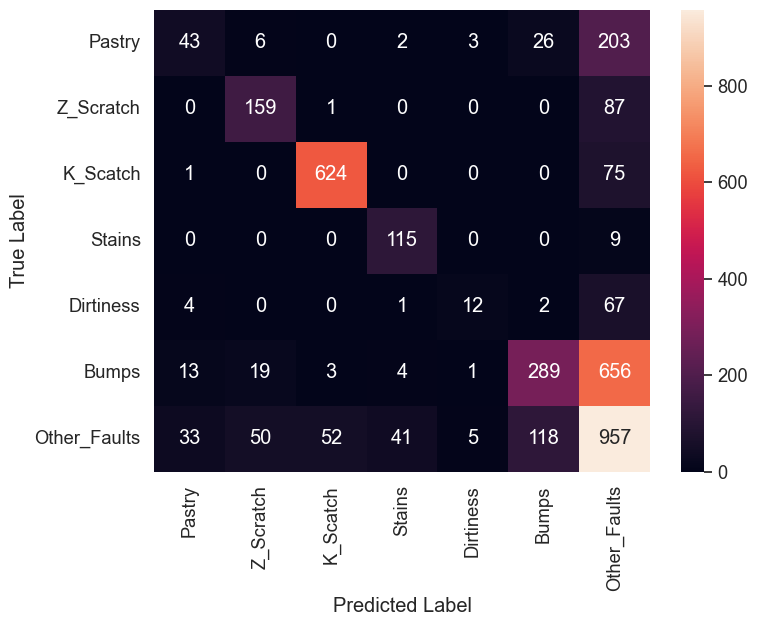

In [151]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, 
                               y_pred=np.argmax(y_prob_vot_comb, axis=1))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(conf_matrix, annot=True, fmt='d'
            , 
            xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Predicting the Test Data

In [152]:
test_df_

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,X_distance,Y_distance,Color_contrast,Density
0,0.601302,0.585519,1.047219,1.053905,-0.273956,-0.387400,-0.124972,-0.295513,-0.599608,-0.117526,1.348170,0,1,1.385842,0.121836,0.644250,-0.954356,-0.444851,-0.221474,0.765432,0.852608,0.469212,-0.430798,0.658379,1.177228,-0.716861,1.031638,-0.330755,0.008089,0.583576,0.609192
1,1.055176,1.059855,-0.748348,-0.749888,-0.347620,-0.371961,-0.235041,-0.346435,0.259770,0.226818,-0.725607,0,1,-0.674853,-0.587199,0.036331,-1.851982,-0.542722,-1.668172,0.765432,0.852608,0.114170,-0.876414,0.133178,1.655827,-0.054690,1.011238,-0.380085,0.008064,-0.158106,0.181042
2,1.244603,1.261150,-0.907656,-0.909928,-0.368266,-0.320496,-0.210581,-0.368308,0.569146,0.364556,-0.684407,0,1,-0.674853,-0.908913,1.714509,-0.381950,-0.322512,-0.065992,-0.354197,-1.220566,-0.025479,0.009532,-0.171321,-1.274161,0.779581,0.234209,-0.380085,0.008055,-0.417695,-0.231716
3,-1.006015,-1.138436,-0.847200,-0.849186,-0.421537,-0.454304,-0.338995,-0.414231,0.775397,0.777769,1.581642,1,0,0.449162,0.299095,-0.605984,0.932775,-0.563112,0.827584,0.765432,0.852608,-0.751443,-1.307866,-0.855349,0.171472,0.531266,-1.104740,-0.429414,0.008091,-0.417695,-0.301593
4,-0.253933,-0.293399,-0.682771,-0.684010,-0.406244,-0.407986,-0.314535,-0.398913,0.637897,0.364556,1.567908,1,0,-0.300181,1.482501,-1.177109,-0.564935,-0.316395,1.015681,-1.324691,-1.220566,-0.435184,0.009532,-0.600300,-1.371684,0.403422,-0.469017,-0.145771,0.008066,-0.491863,-0.252712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,0.762596,0.750939,-0.733598,-0.735052,-0.362148,-0.341082,-0.180006,-0.385492,-0.187106,-1.770379,-0.732474,0,1,-0.112845,-0.201141,-0.832355,-1.313406,-0.381642,-0.931419,0.404464,0.852608,0.019552,-0.184315,0.587004,1.368585,-1.411813,0.948235,-0.367752,0.008145,-0.751452,-0.186308
12810,1.115193,1.129611,0.690346,0.695411,-0.426890,-0.459451,-0.296190,-0.421599,0.981648,0.846638,-0.670673,0,1,-0.674853,-1.067563,-1.049926,-1.144645,-0.532527,0.728397,0.765432,0.852608,-0.923628,-0.999021,-0.334289,1.278643,0.768927,-1.133841,-0.343088,0.008143,-0.603116,-0.559279
12811,-1.225450,-1.054730,-0.132938,-0.131849,3.785157,3.590821,2.785742,3.669347,-2.077738,0.984376,-0.409734,0,1,-0.674853,-0.925315,1.242571,1.389854,1.881627,-1.764232,-1.878236,-1.220566,2.306247,1.971677,2.130695,-0.329869,0.479637,1.280047,1.531420,0.007256,2.771540,1.090185
12812,1.190214,1.197373,-0.599564,-0.600414,-0.343541,-0.284471,-0.198351,-0.351774,-0.633983,-0.324133,-0.656939,0,1,-0.674853,-1.059047,-1.821024,-1.620944,-0.444851,-1.671300,0.765432,0.852608,0.138117,-0.430798,0.483718,1.532489,-1.018444,0.633224,-0.417081,0.008102,0.509408,-0.110676


In [102]:
test_df.drop('id', axis=1, inplace = True)

In [156]:
test_df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,X_distance,Y_distance,Color_contrast,Density
0,-1.301263,-1.472143,-0.969702,-0.972262,-0.442000,-0.507889,-0.407383,-0.433189,-2.923583,-8.871498,-10.014026,0,1,-1.398041,-0.736913,1.973525,-5.905506,-9.838603,-3.754848,-0.299043,0.541169,-2.613734,-3.689485,-1.762195,2.211161,-4.843318,1.392694,-0.556784,0.008035,-1.619404,-0.812728
1,-1.300412,-1.471195,-0.969702,-0.972263,-0.442020,-0.507802,-0.408464,-0.433189,-2.893693,-8.846901,-10.028255,0,1,-1.436783,-2.961144,-2.943093,-9.371873,-11.882897,-10.281193,-0.299043,0.541169,-3.077136,-4.633354,-3.057046,3.194494,0.729101,1.331366,-0.557392,0.008035,-1.647193,-0.878856
2,-1.300056,-1.470793,-0.969703,-0.972263,-0.442025,-0.507515,-0.408224,-0.433189,-2.882933,-8.837063,-10.027972,0,1,-1.436783,-3.970359,10.629361,-3.695049,-7.283237,-3.053437,-5.341497,-3.756948,-3.259405,-2.756809,-3.807771,-2.825479,7.749797,-1.004496,-0.557392,0.008035,-1.656919,-0.942607
3,-1.304280,-1.475588,-0.969703,-0.972263,-0.442039,-0.508262,-0.409486,-0.433189,-2.875760,-8.807547,-10.012424,1,0,-1.415651,-0.180856,-8.137888,1.382027,-12.308791,0.977659,-0.299043,0.541169,-4.206932,-5.547224,-5.494201,0.144728,5.660140,-5.029574,-0.558001,0.008035,-1.656919,-0.953399
4,-1.302868,-1.473899,-0.969702,-0.972263,-0.442035,-0.508003,-0.409245,-0.433189,-2.880542,-8.837063,-10.012518,1,0,-1.429739,3.531472,-12.756922,-4.401683,-7.155468,1.826205,-9.712297,-3.756948,-3.794151,-2.756809,-4.865393,-3.025850,4.584277,-3.118496,-0.554502,0.008035,-1.659698,-0.945850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,-1.300961,-1.471813,-0.969702,-0.972263,-0.442024,-0.507630,-0.407923,-0.433189,-2.909236,-8.989562,-10.028302,0,1,-1.426217,-1.750086,-9.968682,-7.292053,-8.518331,-6.957554,-1.924730,0.541169,-3.200630,-3.167401,-1.938165,2.604326,-10.691600,1.141972,-0.557240,0.008035,-1.669424,-0.935593
12810,-1.300299,-1.471056,-0.969702,-0.972262,-0.442041,-0.508290,-0.409065,-0.433189,-2.868586,-8.802627,-10.027878,0,1,-1.436783,-4.468040,-11.728313,-6.640346,-11.669950,0.530207,-0.299043,0.541169,-4.431668,-4.893053,-4.209560,2.419530,7.660141,-5.117056,-0.556936,0.008035,-1.663866,-0.993199
12811,-1.304692,-1.475420,-0.969702,-0.972263,-0.440923,-0.485702,-0.378780,-0.433180,-2.974992,-8.792789,-10.026088,0,1,-1.436783,-4.021809,6.812512,3.147127,38.755955,-10.714536,-12.205286,-3.756948,-0.216038,1.399261,1.867713,-0.885331,5.225656,2.139448,-0.533816,0.008035,-1.537426,-0.738438
12812,-1.300158,-1.470921,-0.969702,-0.972263,-0.442019,-0.507314,-0.408104,-0.433189,-2.924778,-8.886256,-10.027784,0,1,-1.436783,-4.441326,-17.964655,-8.479673,-9.838603,-10.295302,-0.299043,0.541169,-3.045880,-3.689485,-2.192811,2.941084,-7.381252,0.195001,-0.557849,0.008035,-1.622182,-0.923912


In [157]:
test_prediction_vot = voting_classifier_comb.predict_proba(test_df_)
test_prediction_vot = pd.DataFrame(test_prediction_vot, columns = y.keys())
submission_vot = pd.concat([test_ids, test_prediction_vot],axis = 1)
submission_vot

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.489335,0.003057,0.004682,0.000400,0.019357,0.161280,0.321890
1,19220,0.311663,0.027286,0.009707,0.000579,0.179889,0.148675,0.322202
2,19221,0.003698,0.034643,0.059551,0.000820,0.013757,0.339497,0.548034
3,19222,0.179050,0.005517,0.001096,0.001701,0.011340,0.381227,0.420069
4,19223,0.003191,0.004866,0.001598,0.002593,0.007795,0.644668,0.335290
...,...,...,...,...,...,...,...,...
12809,32028,0.070518,0.098195,0.007083,0.000529,0.027158,0.227912,0.568605
12810,32029,0.172201,0.005861,0.021663,0.009520,0.117836,0.229858,0.443061
12811,32030,0.000372,0.000464,0.956774,0.000120,0.000394,0.000975,0.040902
12812,32031,0.505616,0.007576,0.021648,0.000370,0.046279,0.114693,0.303818


In [158]:
submission_vot.to_csv('submission.csv', index = False)